<a href="https://colab.research.google.com/github/ClaireZzhao/Association-Analysis-using-Google-Merchandise-Store-dataset-/blob/main/%EC%97%B0%EA%B4%80%EC%84%B1_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLASS101 x PAP : 데이터 분석을 통한 프로덕트 개선 아이디어 발굴**



### Q. 유저들이 어떤 특성을 가지고 있을 때 또는 어떤 페이지를 방문했을 때 결제까지 전환되는 경향을 보일까요?

<font color='Grey'>**About the Notebook**</font>
![image](https://drive.google.com/uc?id=1J3xXeF9Kz-R3Ytqs0TRfff_wNWhE2Ov8)

<font color='Grey'>**Column Description**</font>

| Column Name | Description |
| --- | --- |
| date | 페이지 조회가 발생한 일자 |
| timestamp | 페이지 조회가 발생한 시각 |
| full_visitor_id | 유저 ID |
| visit_id | 세션 ID |
| operating_system | 세션의 OS |
| country | 세션의 국가 |
| source | 세션의 유입 소스 |
| medium | 세션의 유입 매체 |
| page_path | 조회한 페이지의 경로 |
| page_title | 조회한 페이지 명 |

# 1. 세팅과 데이터셋 로드

분석에 필요한 라이브러리를 불러옵니다.

In [1]:
# 데이터 전처리에 필요한 라이브러리 로드
import pandas as pd
import numpy as np

In [2]:
# 연관성 분석에 필요한 라이브러리 로드
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import math             

In [3]:
# 시각화에 필요한 라이브러리 로드
import matplotlib.pyplot as plt 
import seaborn as sns    

In [4]:
# 데이터셋 로드 위해 코랩 라이브러리 로드
from google.colab import drive

<font color='Blue'>(추천)</font>
Colab Notebook 이 들어있는 폴더에 CSV 파일도 함께 저장해두는 것이 깔끔합니다.

<font color='Red'>(주의)</font>
CSV 파일을 읽어올 수 있도록, 안내를 따라해서 pd.read_csv() 안의 경로를 저장하신 CSV 파일의 위치로 변경해주세요.


In [5]:
# 데이터셋 읽어오기
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
# 경로 복사해서 '__' 사이에 붙여주기
df = pd.read_csv('/content/drive/MyDrive/PAP_CH5_exercise_dataset.csv')

In [7]:
# 데이터셋 확인하기
df.head()

,Unnamed: 0,date,timestamp,full_visitor_id,visit_id,operating_system,country,source,medium,page_path,page_title
0,0,2017-03-03,2017-03-03 00:22:00,2716943575103073656,1488529162,Android,India,google,organic,/google+redesign/bags/water+bottles+and+tumblers,Water Bottles & Tumblers | Drinkware | Google ...
1,1,2017-03-03,2017-03-03 00:22:00,2716943575103073656,1488529162,Android,India,google,organic,/google+redesign/bags/backpacks/home,Backpacks | Bags | Google Merchandise Store
2,2,2017-03-03,2017-03-03 00:22:00,2716943575103073656,1488529162,Android,India,google,organic,/google+redesign/shop+by+brand/youtube,YouTube | Shop by Brand | Google Merchandise S...
3,3,2017-03-03,2017-03-03 00:22:00,7894637781859655877,1488528466,iOS,United States,(direct),(none),/google+redesign/drinkware/bottles/20oz+stainl...,20 oz Stainless Steel Insulated Tumbler
4,4,2017-03-03,2017-03-03 00:22:00,910312793555708068,1488529363,Android,India,(direct),(none),/google+redesign/shop+by+brand/youtube,YouTube | Shop by Brand | Google Merchandise S...


<font color='Red'>(주의)</font>
대부분의 행동 로그 데이터는 위처럼, 한 행 한 행 유저의 개별 행동으로 구성됩니다. 따라서 유저 수가 많을 경우 데이터 기간을 조금만 늘려도 데이터셋 사이즈가 어마무시하게 커질 수 있습니다.

In [8]:
# 데이터셋 확인하기
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912180 entries, 0 to 1912179
Data columns (total 11 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Unnamed: 0        int64 
 1   date              object
 2   timestamp         object
 3   full_visitor_id   uint64
 4   visit_id          int64 
 5   operating_system  object
 6   country           object
 7   source            object
 8   medium            object
 9   page_path         object
 10  page_title        object
dtypes: int64(2), object(8), uint64(1)
memory usage: 160.5+ MB


# 2. 데이터에서 User Properties 추려내기

User Properties는 사용자 속성값으로 `연령`, `지역`, `디바이스 정보`, `유입 출처` 등으로 정의될 수 있습니다.

<font color='Red'>(주의)</font> 실습 데이터셋에서는 아래와 같은 사용자 속성값 변수가 존재합니다.
- OS (operating_system)
- 유입 소스 (source)
- 유입 매체 (medium)
- 국가 (country)

In [9]:
# OS를 기준으로 집계하여 로그 개수를 확인하기 
df.groupby(by = 'operating_system').count().sort_values(by = 'full_visitor_id', ascending = False)['full_visitor_id'].to_frame()

,full_visitor_id
operating_system,
Macintosh,672530
Windows,601748
Android,219277
iOS,209270
Chrome OS,108476
Linux,95527
(not set),3564
Windows Phone,1188
Samsung,247


In [10]:
# OS 중 로그 개수 상위 10개만 사용하기 (적절한 수의 연관 규칙 생성을 위해)
os_list = df['operating_system'].value_counts().nlargest(10).index.to_list()
os_list

['Macintosh',
 'Windows',
 'Android',
 'iOS',
 'Chrome OS',
 'Linux',
 '(not set)',
 'Windows Phone',
 'Samsung',
 'BlackBerry']

In [11]:
# 유입 소스를 기준으로 집계하여 로그 개수를 확인하기 
df.groupby(by = 'source').count().sort_values(by = 'full_visitor_id', ascending = False)['full_visitor_id'].to_frame()

,full_visitor_id
source,
(direct),1105584
google,613048
youtube.com,61860
Partners,21573
dfa,18722
...,...
google.rs,1
google.sk,1
images.google.co.in,1


In [12]:
# 유입 소스 중 로그 개수 상위 30개만 사용하기 (적절한 수의 연관 규칙 생성을 위해)
source_list = df['source'].value_counts().nlargest(30).index.to_list()
source_list

['(direct)',
 'google',
 'youtube.com',
 'Partners',
 'dfa',
 'analytics.google.com',
 'google.com',
 'sites.google.com',
 'facebook.com',
 'm.facebook.com',
 'mail.google.com',
 'siliconvalley.about.com',
 'bing',
 'qiita.com',
 'reddit.com',
 'yahoo',
 'groups.google.com',
 'l.facebook.com',
 't.co',
 'quora.com',
 'dealspotr.com',
 'blog.golang.org',
 'plus.google.com',
 'baidu',
 'docs.google.com',
 'phandroid.com',
 'sashihara.jp',
 'google.co.jp',
 'duckduckgo.com',
 'productforums.google.com']

In [13]:
# 유입 매체 기준으로 집계하여 로그 개수를 확인하기, 유입 매체는 총 7개로 모두 활용하기
df.groupby(by = 'medium').count().sort_values(by = 'full_visitor_id', ascending = False)['full_visitor_id'].to_frame()

,full_visitor_id
medium,
(none),1105584
organic,578270
referral,143812
cpc,42440
affiliate,21572
cpm,20219
(not set),283


In [14]:
# 국가 기준으로 집계하여 로그 개수를 확인하기 
df.groupby(by = 'country').count().sort_values(by = 'full_visitor_id', ascending = False)['full_visitor_id'].to_frame()

,full_visitor_id
country,
United States,1231565
Canada,77628
India,66445
United Kingdom,50266
Japan,29866
...,...
Samoa,1
Eritrea,1
Equatorial Guinea,1


In [15]:
# 국가 중 로그 개수 상위 10개만 사용하기 (적절한 수의 연관 규칙 생성을 위해)
country_list = df['country'].value_counts().nlargest(10).index.to_list()
country_list

['United States',
 'Canada',
 'India',
 'United Kingdom',
 'Japan',
 'Germany',
 'Australia',
 'Taiwan',
 'France',
 'Brazil']

<font color='Blue'>(추천)</font> 실습 데이터셋에서는 수많은 국가, 수많은 유입 소스가 있어서 적절한 개수의 연관 규칙 생성을 위해 상위 값들만 분석에 활용합니다. 실무에서 활용하실 때에는 
1. 어떤 User Properties를 연관성 분석에 활용할 것인지를 정함
2. 그 변수들이 가지는 고유 값의 개수를 확인함
3. 강의용 스크립트처럼 일부 고유값들만 분석에 활용해야 할 경우, 로그 개수를 세어 상위 n개 값들만 분석에 활용하는 것이 하나의 방법임

으로 진행하시면 됩니다.


# 3. 데이터에서 Events 추려내기

Events는 사용자의 행동을 의미하며 `페이지 또는 버튼` `조회`, `클릭` 등으로 구성됩니다. 실습 데이터셋에서는 `조회` 만 존재합니다.

<font color='Red'>(주의)</font> 실습 데이터셋에서는 아래와 같은 행동 변수가 존재합니다.
- 페이지명 (page_title)

In [16]:
# 페이지 명 기준으로 집계하여 로그 개수 확인하기
df.groupby(by = 'page_title').count().sort_values(by = 'full_visitor_id', ascending = False)['full_visitor_id'].to_frame()

,full_visitor_id
page_title,
YouTube | Shop by Brand | Google Merchandise Store,149617
Men's T-Shirts | Apparel | Google Merchandise Store,98980
Men's Outerwear | Apparel | Google Merchandise Store,54238
Backpacks | Bags | Google Merchandise Store,50148
Store search results,47726
...,...
Google Women's Badge Performance Tee Charcoal,1
Google Youth Tee Fruit Games Lemon,1
Google Youth 짧은 소매 티셔츠 옐로우,1


In [17]:
# 페이지 명 상위 50개만 사용하기 (적절한 수의 연관 규칙 생성을 위해)
page_title_list = df['page_title'].value_counts().nlargest(50).index.to_list()
page_title_list

['YouTube | Shop by Brand | Google Merchandise Store',
 "Men's T-Shirts | Apparel | Google Merchandise Store",
 "Men's Outerwear | Apparel | Google Merchandise Store",
 'Backpacks | Bags | Google Merchandise Store',
 'Store search results',
 'Apparel | Google Merchandise Store',
 'Bags | Google Merchandise Store',
 'Electronics | Google Merchandise Store',
 "Men's-T-Shirts",
 'Google | Shop by Brand | Google Merchandise Store',
 'Drinkware | Google Merchandise Store',
 'Fun | Accessories | Google Merchandise Store',
 'Office',
 'Checkout Your Information',
 'Stickers | Accessories | Google Merchandise Store',
 'Accessories | Google Merchandise Store',
 "Men's Apparel | Google Merchandise Store",
 'Office | Google Merchandise Store',
 'Audio | Electronics | Google Merchandise Store',
 'Water Bottles & Tumblers | Drinkware | Google Merchandise Store',
 'Payment Method',
 'Electronics',
 'Drinkware',
 'Headgear | Apparel | Google Merchandise Store',
 'Mugs & Cups | Drinkware | Google Merc

<font color='Blue'>(추천)</font> 실습 데이터셋에서는 수많은 Event 들이 테이블에 들어 있어서, 적절한 개수의 연관 규칙 생성을 위해 상위 50개만 분석에 활용하였습니다. 실무에서 활용하실 때에는 

1. 필요한 행동 로그를 정의함 
2. 행동 로그를 수집하기 위한 테이블을 찾음 
3. 연관성 분석을 위한 데이터셋을 준비함 

의 절차로 진행하시면 됩니다. 이 부분이 Fine tune 되어야 하는 영역이고 또 어렵습니다.

# 4. 최종 데이터셋 정제하기 

최종 Apriori Algorithm에 들어갈 데이터셋을 준비합니다.

In [18]:
# 필요한 컬럼만 따로 데이터프레임으로 생성하기
data = df[['full_visitor_id','visit_id','operating_system','country','source','medium','page_title']]

# 데이터 셋의 (행, 열) 확인
print(data.shape)

data.head()

(1912180, 7)


,full_visitor_id,visit_id,operating_system,country,source,medium,page_title
0,2716943575103073656,1488529162,Android,India,google,organic,Water Bottles & Tumblers | Drinkware | Google ...
1,2716943575103073656,1488529162,Android,India,google,organic,Backpacks | Bags | Google Merchandise Store
2,2716943575103073656,1488529162,Android,India,google,organic,YouTube | Shop by Brand | Google Merchandise S...
3,7894637781859655877,1488528466,iOS,United States,(direct),(none),20 oz Stainless Steel Insulated Tumbler
4,910312793555708068,1488529363,Android,India,(direct),(none),YouTube | Shop by Brand | Google Merchandise S...


In [19]:
# 위 목차에서 정제한 리스트 값으로만 페이지 명, 국가, 유입 소스를 한정하기 
data = data.loc[data['operating_system'].isin(os_list)]
data = data.loc[data['country'].isin(country_list)]
data = data.loc[data['source'].isin(source_list)]
data = data.loc[data['page_title'].isin(page_title_list)]

# 데이터 셋의 (행, 열) 확인
print(data.shape)
data.head()

(1229279, 7)


,full_visitor_id,visit_id,operating_system,country,source,medium,page_title
0,2716943575103073656,1488529162,Android,India,google,organic,Water Bottles & Tumblers | Drinkware | Google ...
1,2716943575103073656,1488529162,Android,India,google,organic,Backpacks | Bags | Google Merchandise Store
2,2716943575103073656,1488529162,Android,India,google,organic,YouTube | Shop by Brand | Google Merchandise S...
4,910312793555708068,1488529363,Android,India,(direct),(none),YouTube | Shop by Brand | Google Merchandise S...
5,9617510865430151301,1488529161,Windows,Taiwan,(direct),(none),Notebooks & Journals | Office | Google Merchan...


In [20]:
# 세션 ID인 visit_id 와 페이지 명으로 묶어서 해당 페이지를 한 세션 내에서 몇 번 방문했는지 세기
agg = data.groupby(by = ['visit_id', 'page_title']).count()
agg.head()

full_visitor_id  operating_system  country  \
visit_id   page_title                                                    
1470034812 Google                         1                 1        1   
1470035161 Electronics                    2                 2        2   
           Lifestyle                      1                 1        1   
           Men's-Outerwear                1                 1        1   
           YouTube                        1                 1        1   

                            source  medium  
visit_id   page_title                       
1470034812 Google                1       1  
1470035161 Electronics           2       2  
           Lifestyle             1       1  
           Men's-Outerwear       1       1  
           YouTube               1       1

In [21]:
# Group by 함수로 인해서 multi index로 구성된 데이터셋을 피봇 테이블처럼 만들기 위해 index 를 컬럼으로 내려주기
agg = agg.reset_index()
agg

,visit_id,page_title,full_visitor_id,operating_system,country,source,medium
0,1470034812,Google,1,1,1,1,1
1,1470035161,Electronics,2,2,2,2,2
2,1470035161,Lifestyle,1,1,1,1,1
3,1470035161,Men's-Outerwear,1,1,1,1,1
4,1470035161,YouTube,1,1,1,1,1
...,...,...,...,...,...,...,...
771351,1501656843,Audio | Electronics | Google Merchandise Store,1,1,1,1,1
771352,1501656843,Backpacks | Bags | Google Merchandise Store,1,1,1,1,1
771353,1501656843,Men's Apparel | Google Merchandise Store,4,4,4,4,4
771354,1501656998,YouTube | Shop by Brand | Google Merchandise S...,1,1,1,1,1


In [22]:
# Pivot 함수를 통해서 페이지 명으로 구성된 행들을 열(컬럼)으로 바꾸고, 셀에 등록되는 값은 페이지 방문 횟수
events = agg.pivot(index = 'visit_id', columns = 'page_title', values = 'full_visitor_id').reset_index()
events

page_title,visit_id,Accessories | Electronics | Google Merchandise Store,Accessories | Google Merchandise Store,Android | Shop by Brand | Google Merchandise Store,Apparel,Apparel | Google Merchandise Store,Audio | Electronics | Google Merchandise Store,Backpacks | Bags | Google Merchandise Store,Bags,Bags | Google Merchandise Store,...,Stickers | Accessories | Google Merchandise Store,Store search results,Water Bottles & Tumblers | Drinkware | Google Merchandise Store,Women's Apparel | Google Merchandise Store,Women's Outerwear | Apparel | Google Merchandise Store,Women's T-Shirts | Apparel | Google Merchandise Store,Women's-T-Shirts,Writing Instruments | Office | Google Merchandise Store,YouTube,YouTube | Shop by Brand | Google Merchandise Store
0,1470034812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1470035161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,1470035457,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1470035521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0,NaN
4,1470035832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312823,1501656134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312824,1501656404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312825,1501656843,NaN,NaN,NaN,NaN,2.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312826,1501656998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [23]:
# NaN으로 비어있는 값들을 모두 0으로 채워주기
events = events.fillna(0)
events

page_title,visit_id,Accessories | Electronics | Google Merchandise Store,Accessories | Google Merchandise Store,Android | Shop by Brand | Google Merchandise Store,Apparel,Apparel | Google Merchandise Store,Audio | Electronics | Google Merchandise Store,Backpacks | Bags | Google Merchandise Store,Bags,Bags | Google Merchandise Store,...,Stickers | Accessories | Google Merchandise Store,Store search results,Water Bottles & Tumblers | Drinkware | Google Merchandise Store,Women's Apparel | Google Merchandise Store,Women's Outerwear | Apparel | Google Merchandise Store,Women's T-Shirts | Apparel | Google Merchandise Store,Women's-T-Shirts,Writing Instruments | Office | Google Merchandise Store,YouTube,YouTube | Shop by Brand | Google Merchandise Store
0,1470034812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1470035161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1470035457,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1470035521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0
4,1470035832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312823,1501656134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312824,1501656404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312825,1501656843,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312826,1501656998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
events

page_title,visit_id,Accessories | Electronics | Google Merchandise Store,Accessories | Google Merchandise Store,Android | Shop by Brand | Google Merchandise Store,Apparel,Apparel | Google Merchandise Store,Audio | Electronics | Google Merchandise Store,Backpacks | Bags | Google Merchandise Store,Bags,Bags | Google Merchandise Store,...,Stickers | Accessories | Google Merchandise Store,Store search results,Water Bottles & Tumblers | Drinkware | Google Merchandise Store,Women's Apparel | Google Merchandise Store,Women's Outerwear | Apparel | Google Merchandise Store,Women's T-Shirts | Apparel | Google Merchandise Store,Women's-T-Shirts,Writing Instruments | Office | Google Merchandise Store,YouTube,YouTube | Shop by Brand | Google Merchandise Store
0,1470034812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1470035161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1470035457,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1470035521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0
4,1470035832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312823,1501656134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312824,1501656404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312825,1501656843,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312826,1501656998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
# Event 테이블의 통계치 확인
events.describe()

page_title,visit_id,Accessories | Electronics | Google Merchandise Store,Accessories | Google Merchandise Store,Android | Shop by Brand | Google Merchandise Store,Apparel,Apparel | Google Merchandise Store,Audio | Electronics | Google Merchandise Store,Backpacks | Bags | Google Merchandise Store,Bags,Bags | Google Merchandise Store,...,Stickers | Accessories | Google Merchandise Store,Store search results,Water Bottles & Tumblers | Drinkware | Google Merchandise Store,Women's Apparel | Google Merchandise Store,Women's Outerwear | Apparel | Google Merchandise Store,Women's T-Shirts | Apparel | Google Merchandise Store,Women's-T-Shirts,Writing Instruments | Office | Google Merchandise Store,YouTube,YouTube | Shop by Brand | Google Merchandise Store
count,3.128280e+05,312828.000000,312828.000000,312828.000000,312828.000000,312828.000000,312828.000000,312828.000000,312828.000000,312828.000000,...,312828.000000,312828.000000,312828.000000,312828.000000,312828.000000,312828.000000,312828.000000,312828.000000,312828.000000,312828.000000
mean,1.486367e+09,0.056139,0.083605,0.047547,0.052185,0.125526,0.077698,0.131858,0.072503,0.111918,...,0.084037,0.129985,0.084334,0.036272,0.044740,0.074575,0.035659,0.053627,0.030816,0.320278
std,9.172696e+06,0.319863,0.419911,0.307453,0.473205,0.524025,0.420687,0.603030,0.486848,0.552963,...,0.465545,0.664672,0.513426,0.311506,0.371938,0.478051,0.395188,0.406225,0.305734,0.815861
min,1.470035e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.478824e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.486340e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.494531e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.501657e+09,13.000000,21.000000,16.000000,74.000000,33.000000,21.000000,24.000000,34.000000,34.000000,...,14.000000,66.000000,30.000000,19.000000,36.000000,34.000000,58.000000,27.000000,18.000000,31.000000


In [26]:
# 속성값 추려내기 
user_properties = data[['visit_id','operating_system','country','source','medium']]

In [27]:
user_properties

,visit_id,operating_system,country,source,medium
0,1488529162,Android,India,google,organic
1,1488529162,Android,India,google,organic
2,1488529162,Android,India,google,organic
4,1488529363,Android,India,(direct),(none)
5,1488529161,Windows,Taiwan,(direct),(none)
...,...,...,...,...,...
1912171,1501656843,Android,United States,(direct),(none)
1912173,1501656843,Android,United States,(direct),(none)
1912175,1501656843,Android,United States,(direct),(none)
1912176,1501657186,Windows,United Kingdom,(direct),(none)


In [28]:
# 중복 속성값 제거하기
user_properties.drop_duplicates(inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [29]:
user_properties

,visit_id,operating_system,country,source,medium
0,1488529162,Android,India,google,organic
4,1488529363,Android,India,(direct),(none)
5,1488529161,Windows,Taiwan,(direct),(none)
9,1488529256,Windows,Taiwan,(direct),(none)
17,1488529409,Macintosh,United States,google,organic
...,...,...,...,...,...
1912129,1501655396,Macintosh,Australia,(direct),(none)
1912145,1501656404,Macintosh,United States,(direct),(none)
1912161,1501656843,Android,United States,(direct),(none)
1912168,1501656998,Windows,India,(direct),(none)


In [30]:
# Event 테이블에 User Properties 테이블 조인하기, Inner join을 통해 visit_id 가 둘다 존재하는 행만 남기도록 함
dataset = pd.merge(left = events, right = user_properties, how = 'inner', on = 'visit_id')
dataset

,visit_id,Accessories | Electronics | Google Merchandise Store,Accessories | Google Merchandise Store,Android | Shop by Brand | Google Merchandise Store,Apparel,Apparel | Google Merchandise Store,Audio | Electronics | Google Merchandise Store,Backpacks | Bags | Google Merchandise Store,Bags,Bags | Google Merchandise Store,...,Women's Outerwear | Apparel | Google Merchandise Store,Women's T-Shirts | Apparel | Google Merchandise Store,Women's-T-Shirts,Writing Instruments | Office | Google Merchandise Store,YouTube,YouTube | Shop by Brand | Google Merchandise Store,operating_system,country,source,medium
0,1470034812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,iOS,United States,(direct),(none)
1,1470035161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,Windows,Canada,google,organic
2,1470035457,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Android,United States,google,organic
3,1470035521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,4.0,0.0,1.0,0.0,iOS,United Kingdom,(direct),(none)
4,1470035832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,iOS,United States,(direct),(none)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314781,1501656134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Macintosh,United States,(direct),(none)
314782,1501656404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Macintosh,United States,(direct),(none)
314783,1501656843,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Android,United States,(direct),(none)
314784,1501656998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,Windows,India,(direct),(none)


In [31]:
# 데이터셋에서 user properties (operating_system, country, source, medium) 범주형 변수를 0,1로 구성된 더미 변수화
dataset = pd.get_dummies(dataset)
dataset

,visit_id,Accessories | Electronics | Google Merchandise Store,Accessories | Google Merchandise Store,Android | Shop by Brand | Google Merchandise Store,Apparel,Apparel | Google Merchandise Store,Audio | Electronics | Google Merchandise Store,Backpacks | Bags | Google Merchandise Store,Bags,Bags | Google Merchandise Store,...,source_t.co,source_yahoo,source_youtube.com,medium_(none),medium_(not set),medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral
0,1470034812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,1470035161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,1470035457,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,1470035521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,1470035832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314781,1501656134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
314782,1501656404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
314783,1501656843,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
314784,1501656998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [32]:
# 더미변수가 아닌 경우 event 연속형 변수(0 ~ 무한대) 를 0,1로 구성되도록 변환
dataset = dataset.applymap(lambda x: 1 if x > 0 else 0)
dataset

,visit_id,Accessories | Electronics | Google Merchandise Store,Accessories | Google Merchandise Store,Android | Shop by Brand | Google Merchandise Store,Apparel,Apparel | Google Merchandise Store,Audio | Electronics | Google Merchandise Store,Backpacks | Bags | Google Merchandise Store,Bags,Bags | Google Merchandise Store,...,source_t.co,source_yahoo,source_youtube.com,medium_(none),medium_(not set),medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314781,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
314782,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
314783,1,0,0,0,0,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
314784,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [33]:
# 불필요한 visit_id를 삭제하고 최종 데이터셋 확인하기 
del dataset['visit_id']

In [34]:
dataset

,Accessories | Electronics | Google Merchandise Store,Accessories | Google Merchandise Store,Android | Shop by Brand | Google Merchandise Store,Apparel,Apparel | Google Merchandise Store,Audio | Electronics | Google Merchandise Store,Backpacks | Bags | Google Merchandise Store,Bags,Bags | Google Merchandise Store,Checkout Confirmation,...,source_t.co,source_yahoo,source_youtube.com,medium_(none),medium_(not set),medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
314782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
314783,0,0,0,0,1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
314784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# 5. Association Rule Learning 진행하기 

Apriori 알고리즘을 활용하여 부분집합들을 생성합니다.

In [96]:
# Apriori 함수를 통해 최소 지지도(min_support)를 입력하고 itemsets 의 최대 원소 개수(max_len)를 입력하여 필요한 부분 집합들을 생성하기 
# min_support = 0 과 length = 2 으로 정성적으로 설정
frequent_featuresets = apriori(dataset, min_support = 0, use_colnames = True, max_len = 2) 
frequent_featuresets

,support,itemsets
0,0.042206,(Accessories | Electronics | Google Merchandis...
1,0.058020,(Accessories | Google Merchandise Store)
2,0.035002,(Android | Shop by Brand | Google Merchandise ...
3,0.026615,(Apparel)
4,0.085506,(Apparel | Google Merchandise Store)
...,...,...
5773,0.000000,"(medium_organic, medium_cpc)"
5774,0.000000,"(medium_cpc, medium_referral)"
5775,0.000000,"(medium_organic, medium_cpm)"
5776,0.000000,"(medium_referral, medium_cpm)"


In [98]:
# 부분 집합들을 지지도(support)를 기준으로 정렬하기 
# ascending = False 는 내림차순, inplace = True 는 정렬해서 보여주는 것과 동시에 데이터셋의 실제 정렬 순서를 바꿔두겠다는 의미
frequent_featuresets.sort_values(by='support', ascending = False, inplace = True)
frequent_featuresets

,support,itemsets
69,0.705435,(country_United States)
100,0.545961,(medium_(none))
5141,0.545961,"(medium_(none), source_(direct))"
70,0.545961,(source_(direct))
5105,0.415120,"(medium_(none), country_United States)"
...,...,...
5195,0.000000,"(source_analytics.google.com, source_l.faceboo..."
5184,0.000000,"(source_analytics.google.com, source_bing)"
5196,0.000000,"(source_analytics.google.com, source_m.faceboo..."
5198,0.000000,"(source_analytics.google.com, source_phandroid..."


Association rule 함수를 통해 향상도(lift)를 계산하고 향상도 내림차순으로 정렬합니다.

In [99]:
# 향상도(lift) 지표를 계산하도록 Association rule 함수를 활용함
# min_threshold 는 X, Y 의 두 가지가 함께 등장하는 비율(support 컬럼)이 최소 몇 이상이어야 하는지를 나타냄 
rules = association_rules(frequent_featuresets, metric = 'lift', min_threshold = 0.001)

In [63]:
type(rules)

pandas.core.frame.DataFrame

In [100]:
# consequents 에 결제 완료 페이지 조회를 포함하도록 조건을 걸고, 향상도 기준으로 내림차순 정렬하여 확인함
# str.contains 는 문자열에서 특정 문자를 찾는 함수이며 regex = False 는 정규 표현식 형태가 아닌 것을 의미, na = False 는 비어있는 값을 채우는 것을 의미함
result = rules[rules['consequents'].str.contains('Checkout Review', regex = False, na = False)].sort_values(by = 'lift', ascending = False)
result.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
224,(Checkout Confirmation),(Checkout Review),0.036171,0.036202,0.033035,0.913315,25.228032,0.031726,11.118338
183,(Payment Method),(Checkout Review),0.052105,0.036202,0.036174,0.694245,19.176771,0.034287,3.152185
213,(Checkout Your Information),(Checkout Review),0.059348,0.036202,0.033941,0.571887,15.796959,0.031792,2.251271
5539,(source_dealspotr.com),(Checkout Review),0.000413,0.036202,0.000133,0.323077,8.924192,0.000118,1.423792
1183,(Shopping Cart),(Checkout Review),0.027110,0.036202,0.008183,0.301851,8.337891,0.007202,1.380505
5189,(source_mail.google.com),(Checkout Review),0.001671,0.036202,0.000213,0.127376,3.518455,0.000152,1.104483
2076,(Writing Instruments | Office | Google Merchan...,(Checkout Review),0.030935,0.036202,0.003761,0.121586,3.358497,0.002641,1.097201
1689,(Water Bottles & Tumblers | Drinkware | Google...,(Checkout Review),0.047639,0.036202,0.005289,0.111030,3.066915,0.003565,1.084173
1963,(Notebooks & Journals | Office | Google Mercha...,(Checkout Review),0.038988,0.036202,0.004120,0.105679,2.919122,0.002709,1.077687
6107,(source_l.facebook.com),(Checkout Review),0.000693,0.036202,0.000070,0.100917,2.787592,0.000045,1.071979


<font color='Red'>(중요)</font> **출력 결과 이해하기**

* antecedents = X 
* consequents = Y
* antecedents support = 전체 세션 중에서 X 페이지 조회한 세션의 비율
* consequents support = 전체 세션 중에서 Y 페이지 조회한 세션의 비율 `(Checkout Review = 결제 완료 페이지)`
* support = 전체 세션 중에서 X, Y 페이지 모두 조회한 세션의 비율 (X∩Y)
* confidence = X 페이지 조회한 세션 비율 중 Y 페이지까지 조회한 세션의 비율 (support/antecedents support)
* lift = X 페이지 조회했을 때, Y 페이지를 조회한 세션의 비율 (confidence) / X 페이지 조회와 관계 없이, 전체 세션 중에서 Y 페이지 조회한 세션의 비율 (consequents support)



Math 라이브러리를 활용해서 향상도와 지지도를 곱한 후 제곱근을 씌워줍니다.

그 후 교차지지도(Interest-Support) 기준으로 내림차순 정렬합니다.

In [101]:
# consequents 에 결제 완료 페이지 조회를 포함하도록 조건을 걸고, 향상도 기준으로 내림차순 정렬하여 확인함
# str.contains 는 문자열에서 특정 문자를 찾는 함수이며 regex = False 는 정규 표현식 형태가 아닌 것을 의미, na = False 는 비어있는 값을 채우는 것을 의미함
rules['interest_support'] = rules['lift']*rules['support'].apply(lambda x: math.sqrt(x))
result = rules[rules['consequents'].str.contains('Checkout Review', regex = False, na = False)].sort_values(by = 'interest_support', ascending = False)

result.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,interest_support
224,(Checkout Confirmation),(Checkout Review),0.036171,0.036202,0.033035,0.913315,25.228032,0.031726,11.118338,4.585339
183,(Payment Method),(Checkout Review),0.052105,0.036202,0.036174,0.694245,19.176771,0.034287,3.152185,3.647308
213,(Checkout Your Information),(Checkout Review),0.059348,0.036202,0.033941,0.571887,15.796959,0.031792,2.251271,2.910266
1183,(Shopping Cart),(Checkout Review),0.027110,0.036202,0.008183,0.301851,8.337891,0.007202,1.380505,0.754261
434,(operating_system_Macintosh),(Checkout Review),0.298762,0.036202,0.020658,0.069147,1.910013,0.009843,1.035392,0.274527
201,(country_United States),(Checkout Review),0.705435,0.036202,0.035081,0.049730,1.373655,0.009543,1.014235,0.257284
280,(source_(direct)),(Checkout Review),0.545961,0.036202,0.028060,0.051396,1.419691,0.008295,1.016017,0.237816
282,(medium_(none)),(Checkout Review),0.545961,0.036202,0.028060,0.051396,1.419691,0.008295,1.016017,0.237816
1689,(Water Bottles & Tumblers | Drinkware | Google...,(Checkout Review),0.047639,0.036202,0.005289,0.111030,3.066915,0.003565,1.084173,0.223049
2076,(Writing Instruments | Office | Google Merchan...,(Checkout Review),0.030935,0.036202,0.003761,0.121586,3.358497,0.002641,1.097201,0.205974


# 6. 결과 정리와 시각화

In [102]:
# Association Rule 진행한 결과 데이터셋 활용하기 위해 antecedents 에서 () 없애주기 
result['antecedents'] = result["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")

In [103]:
result['antecedents']

224           Checkout Confirmation
183                  Payment Method
213       Checkout Your Information
1183                  Shopping Cart
434      operating_system_Macintosh
                   ...             
7634    source_analytics.google.com
8115              source_reddit.com
6587             source_youtube.com
8419     operating_system_(not set)
8477               source_qiita.com
Name: antecedents, Length: 99, dtype: object

Trivial Rules, Useful Rules 를 구분합니다.

In [104]:
# 결제 전환 퍼널에 속하는 페이지들을 제외함
trivial_rules = ['Checkout Confirmation', 'Payment Method', 'Checkout Your Information']
filtered_rules = result[~result.antecedents.isin(trivial_rules)]
filtered_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,interest_support
1183,Shopping Cart,(Checkout Review),0.027110,0.036202,0.008183,0.301851,8.337891,0.007202,1.380505,0.754261
434,operating_system_Macintosh,(Checkout Review),0.298762,0.036202,0.020658,0.069147,1.910013,0.009843,1.035392,0.274527
201,country_United States,(Checkout Review),0.705435,0.036202,0.035081,0.049730,1.373655,0.009543,1.014235,0.257284
280,source_(direct),(Checkout Review),0.545961,0.036202,0.028060,0.051396,1.419691,0.008295,1.016017,0.237816
282,medium_(none),(Checkout Review),0.545961,0.036202,0.028060,0.051396,1.419691,0.008295,1.016017,0.237816


Trivial Rules 를 제외한 데이터셋을 향상도(lift) 기준으로 내림차순 정렬합니다.

In [105]:
# 정렬과 동시에 인덱스를 저장해둠
lift_top = filtered_rules.sort_values(by = 'lift', ascending = False).head(15).index.to_list()
filtered_rules.sort_values(by = 'lift', ascending = False).head(15)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,interest_support
5539,source_dealspotr.com,(Checkout Review),0.000413,0.036202,0.000133,0.323077,8.924192,0.000118,1.423792,0.103083
1183,Shopping Cart,(Checkout Review),0.027110,0.036202,0.008183,0.301851,8.337891,0.007202,1.380505,0.754261
5189,source_mail.google.com,(Checkout Review),0.001671,0.036202,0.000213,0.127376,3.518455,0.000152,1.104483,0.051331
2076,Writing Instruments | Office | Google Merchand...,(Checkout Review),0.030935,0.036202,0.003761,0.121586,3.358497,0.002641,1.097201,0.205974
1689,Water Bottles & Tumblers | Drinkware | Google ...,(Checkout Review),0.047639,0.036202,0.005289,0.111030,3.066915,0.003565,1.084173,0.223049
1963,Notebooks & Journals | Office | Google Merchan...,(Checkout Review),0.038988,0.036202,0.004120,0.105679,2.919122,0.002709,1.077687,0.187376
6107,source_l.facebook.com,(Checkout Review),0.000693,0.036202,0.000070,0.100917,2.787592,0.000045,1.071979,0.023304
2576,Other | Office | Google Merchandise Store,(Checkout Review),0.027911,0.036202,0.002796,0.100159,2.766651,0.001785,1.071076,0.146281
2561,Shopping & Totes | Bags | Google Merchandise S...,(Checkout Review),0.028210,0.036202,0.002815,0.099775,2.756029,0.001793,1.070618,0.146215
2473,Sports & Fitness | Accessories | Google Mercha...,(Checkout Review),0.030294,0.036202,0.002993,0.098784,2.728649,0.001896,1.069441,0.149268


Trivial Rules 를 제외한 데이터셋을 교차지지도(interest_support) 기준으로 내림차순 정렬합니다.

In [106]:
# 정렬과 동시에 인덱스를 저장해둠
is_top = filtered_rules.sort_values(by = 'interest_support', ascending = False).head(15).index.to_list()
filtered_rules.sort_values(by = 'interest_support', ascending = False).head(15)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,interest_support
1183,Shopping Cart,(Checkout Review),0.027110,0.036202,0.008183,0.301851,8.337891,0.007202,1.380505,0.754261
434,operating_system_Macintosh,(Checkout Review),0.298762,0.036202,0.020658,0.069147,1.910013,0.009843,1.035392,0.274527
201,country_United States,(Checkout Review),0.705435,0.036202,0.035081,0.049730,1.373655,0.009543,1.014235,0.257284
280,source_(direct),(Checkout Review),0.545961,0.036202,0.028060,0.051396,1.419691,0.008295,1.016017,0.237816
282,medium_(none),(Checkout Review),0.545961,0.036202,0.028060,0.051396,1.419691,0.008295,1.016017,0.237816
1689,Water Bottles & Tumblers | Drinkware | Google ...,(Checkout Review),0.047639,0.036202,0.005289,0.111030,3.066915,0.003565,1.084173,0.223049
2076,Writing Instruments | Office | Google Merchand...,(Checkout Review),0.030935,0.036202,0.003761,0.121586,3.358497,0.002641,1.097201,0.205974
1963,Notebooks & Journals | Office | Google Merchan...,(Checkout Review),0.038988,0.036202,0.004120,0.105679,2.919122,0.002709,1.077687,0.187376
1661,Fun | Accessories | Google Merchandise Store,(Checkout Review),0.065448,0.036202,0.005366,0.081982,2.264557,0.002996,1.049868,0.165879
1859,Mugs & Cups | Drinkware | Google Merchandise S...,(Checkout Review),0.052928,0.036202,0.004492,0.084869,2.344290,0.002576,1.053180,0.157119


In [107]:
# Lift 상위 15개와 IS 상위 15개를 합침
top = lift_top + is_top

In [108]:
# 중복 제거 후 개수 확인
top = list(set(top))
len(top)

21

In [109]:
# 추려낸 연관 규칙 index 만 읽어오도록 하고 향상도 기준으로 내림차순 정렬

filtered_rules = filtered_rules[filtered_rules.index.isin(top)]
filtered_rules.reset_index(inplace = True, drop = True)
print('####### Final Rules #######')
filtered_rules.sort_values(by = 'lift', ascending = False)

####### Final Rules #######


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,interest_support
17,source_dealspotr.com,(Checkout Review),0.000413,0.036202,0.000133,0.323077,8.924192,0.000118,1.423792,0.103083
0,Shopping Cart,(Checkout Review),0.027110,0.036202,0.008183,0.301851,8.337891,0.007202,1.380505,0.754261
18,source_mail.google.com,(Checkout Review),0.001671,0.036202,0.000213,0.127376,3.518455,0.000152,1.104483,0.051331
6,Writing Instruments | Office | Google Merchand...,(Checkout Review),0.030935,0.036202,0.003761,0.121586,3.358497,0.002641,1.097201,0.205974
5,Water Bottles & Tumblers | Drinkware | Google ...,(Checkout Review),0.047639,0.036202,0.005289,0.111030,3.066915,0.003565,1.084173,0.223049
7,Notebooks & Journals | Office | Google Merchan...,(Checkout Review),0.038988,0.036202,0.004120,0.105679,2.919122,0.002709,1.077687,0.187376
20,source_l.facebook.com,(Checkout Review),0.000693,0.036202,0.000070,0.100917,2.787592,0.000045,1.071979,0.023304
11,Other | Office | Google Merchandise Store,(Checkout Review),0.027911,0.036202,0.002796,0.100159,2.766651,0.001785,1.071076,0.146281
12,Shopping & Totes | Bags | Google Merchandise S...,(Checkout Review),0.028210,0.036202,0.002815,0.099775,2.756029,0.001793,1.070618,0.146215
10,Sports & Fitness | Accessories | Google Mercha...,(Checkout Review),0.030294,0.036202,0.002993,0.098784,2.728649,0.001896,1.069441,0.149268


In [120]:
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,interest_support
0,Shopping Cart,(Checkout Review),0.027110,0.036202,0.008183,0.301851,8.337891,0.007202,1.380505,0.754261
1,operating_system_Macintosh,(Checkout Review),0.298762,0.036202,0.020658,0.069147,1.910013,0.009843,1.035392,0.274527
2,country_United States,(Checkout Review),0.705435,0.036202,0.035081,0.049730,1.373655,0.009543,1.014235,0.257284
3,source_(direct),(Checkout Review),0.545961,0.036202,0.028060,0.051396,1.419691,0.008295,1.016017,0.237816
4,medium_(none),(Checkout Review),0.545961,0.036202,0.028060,0.051396,1.419691,0.008295,1.016017,0.237816
5,Water Bottles & Tumblers | Drinkware | Google ...,(Checkout Review),0.047639,0.036202,0.005289,0.111030,3.066915,0.003565,1.084173,0.223049
6,Writing Instruments | Office | Google Merchand...,(Checkout Review),0.030935,0.036202,0.003761,0.121586,3.358497,0.002641,1.097201,0.205974
7,Notebooks & Journals | Office | Google Merchan...,(Checkout Review),0.038988,0.036202,0.004120,0.105679,2.919122,0.002709,1.077687,0.187376
8,Fun | Accessories | Google Merchandise Store,(Checkout Review),0.065448,0.036202,0.005366,0.081982,2.264557,0.002996,1.049868,0.165879
9,Mugs & Cups | Drinkware | Google Merchandise S...,(Checkout Review),0.052928,0.036202,0.004492,0.084869,2.344290,0.002576,1.053180,0.157119


테이블 형태 뿐 아니라 차트로 시각화합니다.

In [114]:
# Plot style 지정하기
plt.style.use('seaborn-darkgrid')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


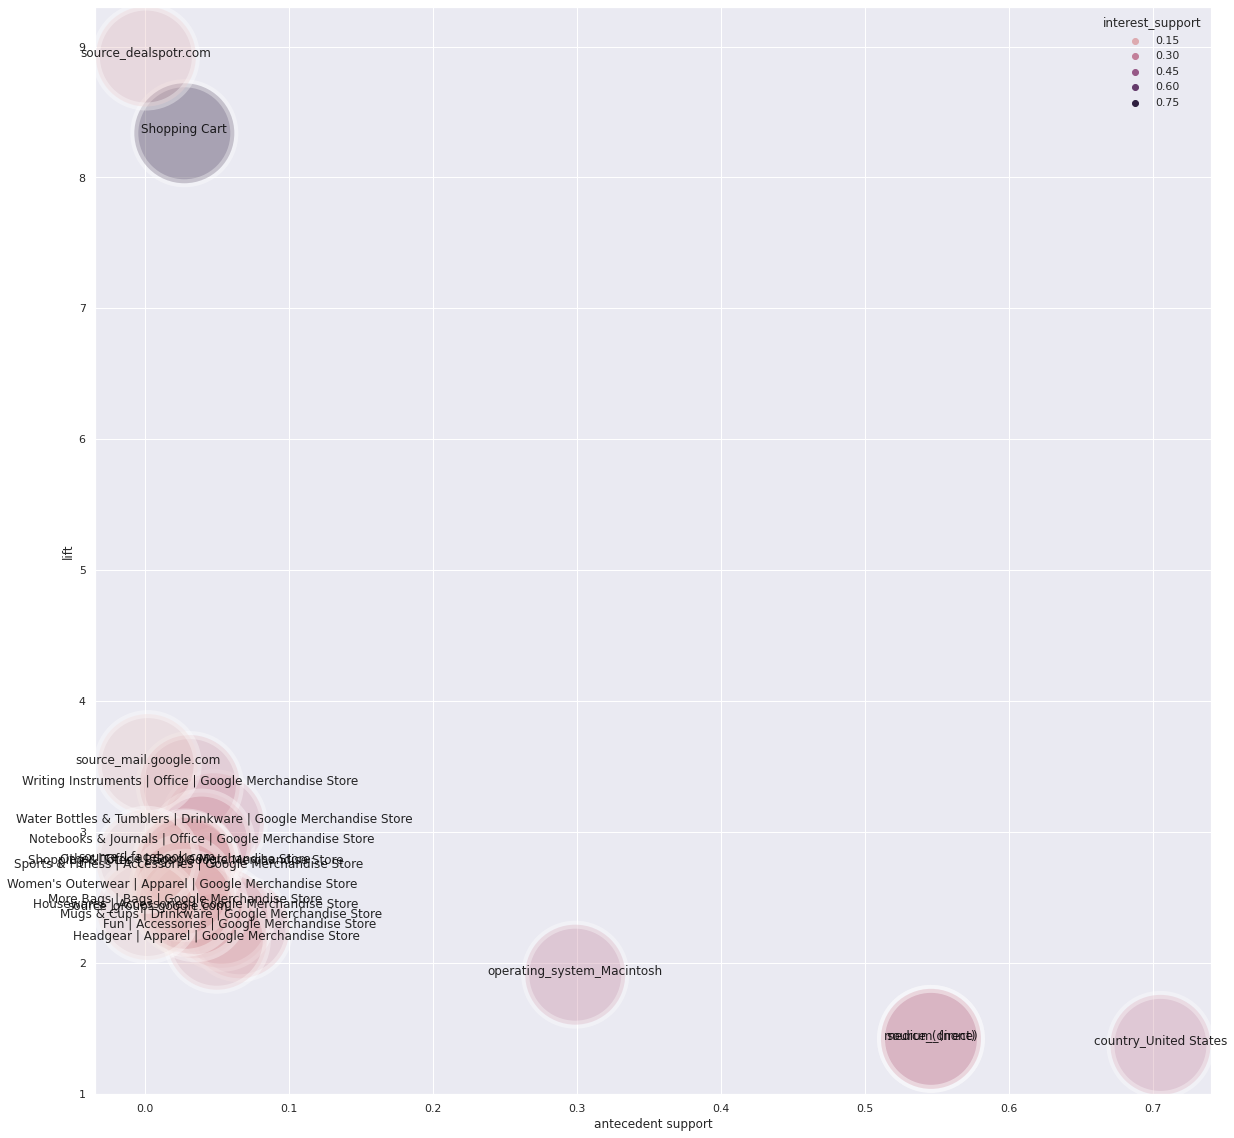

In [121]:
# Plot 틀 잡고 그려내기
plt.figure(figsize = (20,20))

# 폰트 사이즈 지정하기 
sns.set(font_scale = 1)

# 스캐터플랏 그려내기. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(filtered_rules['antecedent support'], filtered_rules['lift'], hue = filtered_rules['interest_support'], s = 10000, alpha = 0.35, color = 'orange')

# 매 데이터 포인트 안에 Antecedent 를 기입하기
for line in range(0,filtered_rules.shape[0]):
     ax.text(filtered_rules['antecedent support'][line], filtered_rules['lift'][line], filtered_rules['antecedents'][line], horizontalalignment='center', size='medium', color='black', weight='ultralight', alpha = 0.85)

# 차트 보이도록 하기
plt.show()

고생하셨습니다! 다시 PPT로 돌아가서 강의를 마무리해볼게요 😀